In [3]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import MathsUtilities as MUte
%matplotlib inline

Lines = ['-','-','-','--','--','--']
Colors = ['r','b','g','r','b','g']
Fills = ['r','b','g','w','w','w']

Crops = ['Maize','Wheat']

## Get Wheat Data

In [4]:
con = sqlite3.connect('D:\GitHubRepos\ApsimX\Tests\Validation\Wheat/Wheat.db')
WheatPredicted = pd.read_sql("Select * from DailyReport where Zone = 'RainShelter'",
                        con)
WheatObserved = pd.read_sql("Select * from Observed where SimulationName Like '%Lincoln2015%'", 
                           con)

WheatIrrigs = ['Full','Nil']
WheatNs = ['0','50','250']
WheatIrrigs2 = ['IrrFull','IrrNil']
WheatNs2 = ['Nit0','Nit50','Nit250']
WheatTreats = []
for Irrig in WheatIrrigs2:
    for Nit in WheatNs2:
        WheatTreats.append(Nit+Irrig)

## Get Maize Data

In [5]:
con = sqlite3.connect('D:\GitHubRepos\ApsimX\Tests\Validation\Maize/Maize.db')
MaizePredicted = pd.read_sql("Select * from Report where Zone = 'RainShelter'",
                        con)
MaizeObserved = pd.read_sql("Select * from Observed where SimulationName Like '%Lincoln2012%'", 
                           con)
MaizeIrrigs = ['Full','Nil']
MaizeNs = ['Nil','Low','Med']
MaizeIrrigs2 = ['IrrFull','IrrNil']
MaizeNs2 = ['NitNil','NitLow','NitMed']
MaizeTreats = []
for Irrig in MaizeIrrigs2:
    for Nit in MaizeNs2:
        MaizeTreats.append(Nit+Irrig)

In [27]:
def ObsPredTimeSeries(Variable,rows,col,ymax):
    pan = 1
    for Crop in Crops:
        Graph.add_subplot(rows,2,col*2+pan)
        pos = 0
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                Pred = Predicted.ix[PredFilter,Crop+'.'+Variable]
                PredIndex = pd.to_datetime(Predicted.ix[PredFilter,'Clock.Today'])
                plt.plot(PredIndex,Pred,Lines[pos],color=Colors[pos],lw=5)

                ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
                Obs = Observed.ix[ObsFilter,Crop+'.'+Variable]
                ObsIndex = pd.to_datetime(Observed.ix[ObsFilter,'Clock.Today'])
                plt.plot(ObsIndex,Obs,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
                pos +=1
            plt.ylim(0,ymax)
        pos = 0
        pan +=1

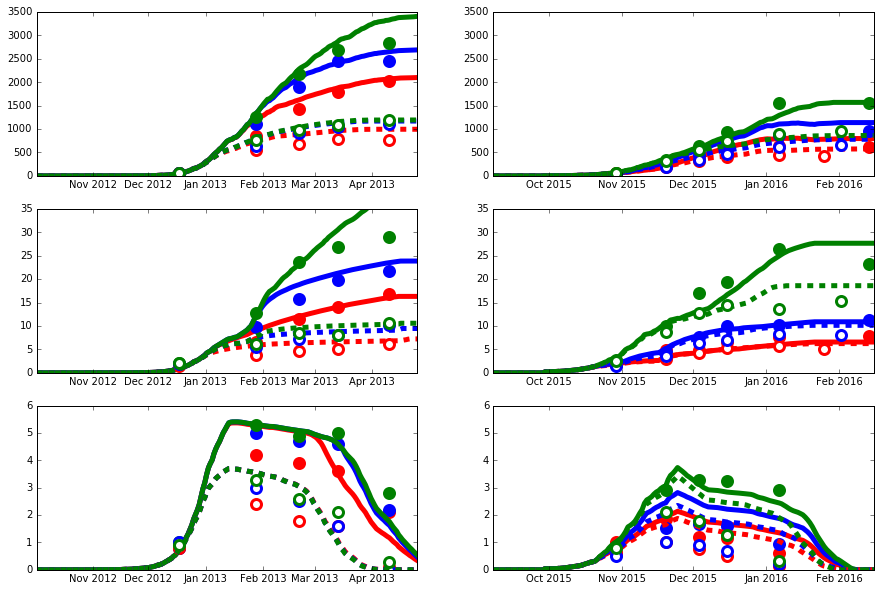

In [28]:
Graph = plt.figure(figsize=(15,10))
cols = 3
ObsPredTimeSeries('AboveGround.Wt',cols,0,3500)
ObsPredTimeSeries('AboveGround.N',cols,1,35)
ObsPredTimeSeries('Leaf.LAI',cols,2,6)

In [29]:
def ObsPredDMPropVTime(Variable,rows,col,ymax):
    pan = 1
    for Crop in Crops:
        Graph.add_subplot(rows,2,col*2+pan)
        pos = 0
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        TotalVal = Crop+'.AboveGround.'+Variable.split('.')[-1:][0]
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                TotalDMPred = Predicted.ix[PredFilter,TotalVal]
                ComponentDMPred = Predicted.ix[PredFilter,Crop+'.'+Variable]/TotalDMPred
                PredIndex = pd.to_datetime(Predicted.ix[PredFilter,'Clock.Today'])
                plt.plot(PredIndex,ComponentDMPred,Lines[pos],color=Colors[pos],lw=5)

                ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
                TotalDMObs = Observed.ix[ObsFilter,TotalVal]
                ComponentDMObs = Observed.ix[ObsFilter,Crop+'.'+Variable]/TotalDMObs
                ObsIndex = pd.to_datetime(Observed.ix[ObsFilter,'Clock.Today'])
                plt.plot(ObsIndex,ComponentDMObs,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
                pos +=1
            plt.ylim(0,ymax)
        xpos = pd.to_datetime(Predicted.ix[:,'Clock.Today'].min())+datetime.timedelta(40)
        plt.text(xpos,ymax*0.9,Variable,fontsize=12)
        pos = 0
        pan +=1

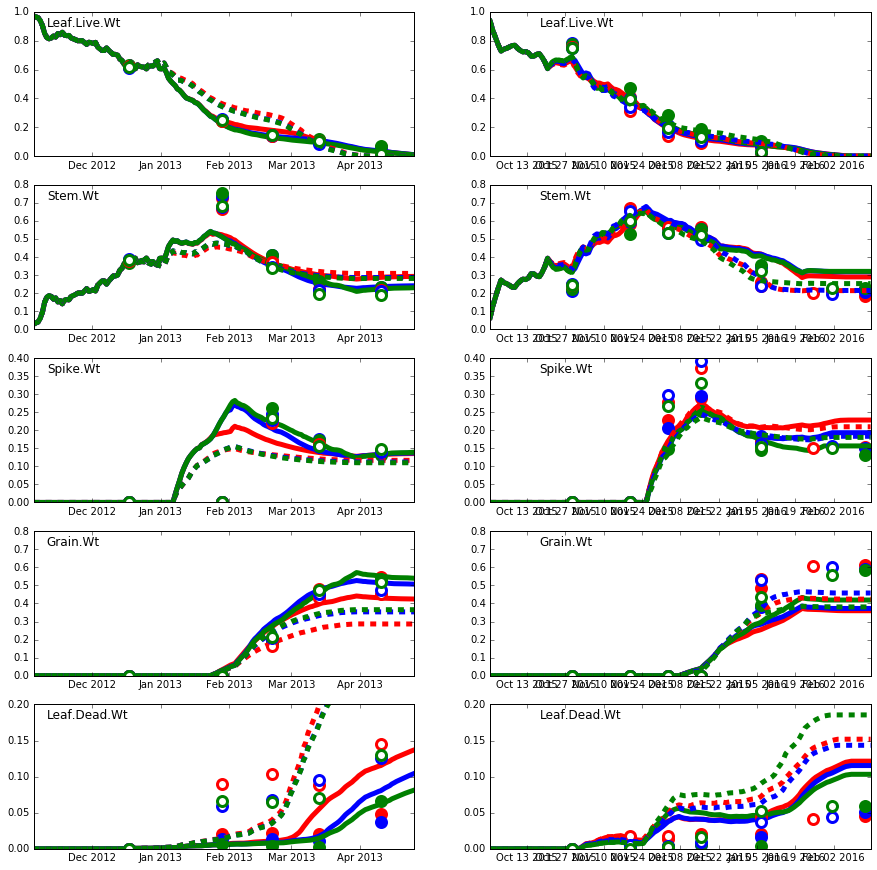

In [30]:
Graph = plt.figure(figsize=(15,15))
cols = 5
ObsPredDMPropVTime('Leaf.Live.Wt',cols,0,1)
ObsPredDMPropVTime('Stem.Wt',cols,1,.8)
ObsPredDMPropVTime('Spike.Wt',cols,2,.4)
ObsPredDMPropVTime('Grain.Wt',cols,3,0.8)
ObsPredDMPropVTime('Leaf.Dead.Wt',cols,4,0.2)

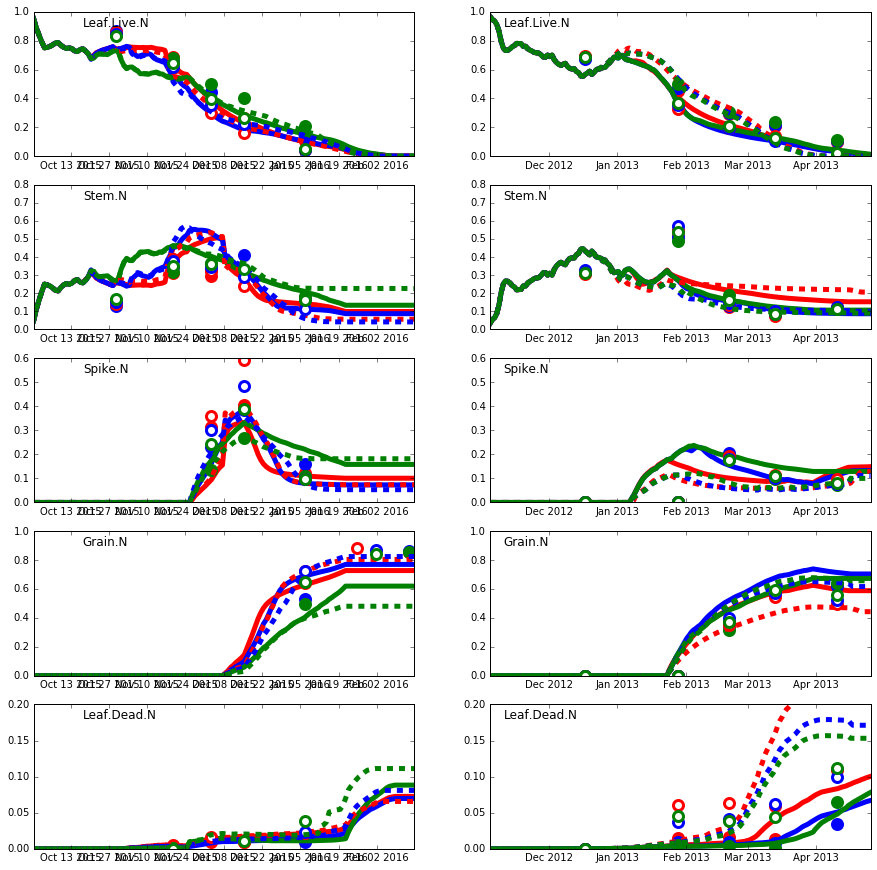

In [23]:
Graph = plt.figure(figsize=(15,15))
cols = 5
ObsPredDMPropVTime('Leaf.Live.N',cols,0,1)
ObsPredDMPropVTime('Stem.N',cols,1,.8)
ObsPredDMPropVTime('Spike.N',cols,2,0.6)
ObsPredDMPropVTime('Grain.N',cols,3,1.0)
ObsPredDMPropVTime('Leaf.Dead.N',cols,4,0.2)

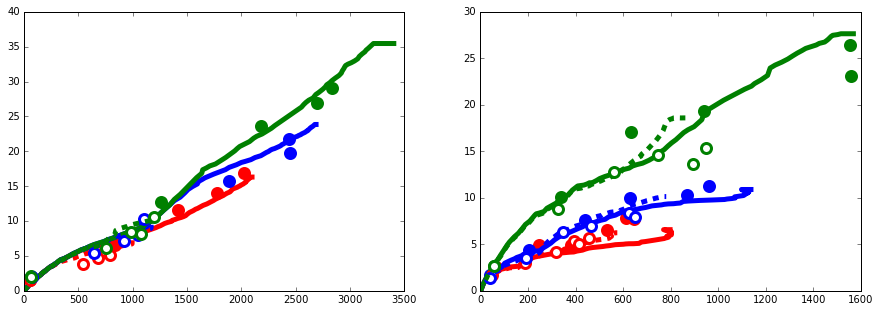

In [37]:
Graph = plt.figure(figsize=(15,5))
pan = 1
for Crop in Crops:
    Graph.add_subplot(1,2,pan)
    pos = 0
    Predicted = globals()[Crop+'Predicted']
    Observed = globals()[Crop+'Observed']
    Treats = globals()[Crop+'Treats']
    Irrigs = globals()[Crop+'Irrigs']
    Ns = globals()[Crop+'Ns']
    for Irrig in Irrigs:
        for N in Ns:
            PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
            TotalDMPred = Predicted.ix[PredFilter,Crop+'.AboveGround.Wt']
            TotalNPred = Predicted.ix[PredFilter,Crop+'.AboveGround.N']
            plt.plot(TotalDMPred,TotalNPred,Lines[pos],color=Colors[pos],lw=5)

            ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
            TotalDMObs = Observed.ix[ObsFilter,Crop+'.AboveGround.Wt']
            TotalNObs = Observed.ix[ObsFilter,Crop+'.AboveGround.N']
            plt.plot(TotalDMObs,TotalNObs,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
            pos +=1
    pan +=1